# <a class="anchor" id="Business-Understanding">Section I : Business Understanding</a>
With the advancements in technology and the growing interest in data, there has been a lot of activities in this area. One of the biggest Health Industry challenges is lacking a central database about patients. Many patients especially ones with chronic diseases visit 14 specialists per year on average. This raises a few issues, mainly that each specialist is treating the patient for one organ and doesn't have a thorough knowledge of the patients previous visits to other doctors or prescribed medications and such. Collection and Preparation of data has been a major challenge in this industry which efforts has been done to overcome this. Organizations like MIT's PhysioNet are providing range of databases which benefits researchers abundantly. They provide a database of patient records called Medical Information Mart for Intensive Care (MIMIC). Using MIMIC-IV clinial data base demo version we'll try to tackle the following question:

#### Question 1: Can patient healthcare records predict the likelihood of mortality in an emergency room visit?

## Table of Contents

I. [Business Understanding](#Business-Understanding)<br>
II. [Data Understanding](#Data-Understanding)<br>
III. [Data Preparation](#Data-Preparation)<br>
IV. [Data Modeling](#Data-Modeling)<br>
V. [Results Evaluation](#Results-Evaluation)<br>
VI. [Conclusion and Discussion](#Conclusion-Discussion)

# <a class="anchor" id="Data-Understanding">Section II : Data Understanding</a>

All data has been collected from PhysioNet official website https://physionet.org/content/mimic-iv-demo/1.0/, using MIMIC-IV Clinical Database Demo Version 1.0.

Database contains:
 * Patient Demographics
 * Patient Admissions
 * Patients ICU Stay Info

### Gather Data
Importing appropriate libraries and Loading required Files and fucntions

In [2]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

# Loading the data
admissions = pd.read_csv("./data/admissions.csv")
patients = pd.read_csv("./data/patients.csv")
icustays = pd.read_csv("./data/icustays.csv")

### Analyze Data

In [3]:
# Checking Null values in each category

round(admissions.isna().sum() / admissions.shape[0], 2)

subject_id              0.00
hadm_id                 0.00
admittime               0.00
dischtime               0.00
deathtime               0.95
admission_type          0.00
admission_location      0.00
discharge_location      0.15
insurance               0.00
language                0.00
marital_status          0.04
ethnicity               0.00
edregtime               0.34
edouttime               0.34
hospital_expire_flag    0.00
dtype: float64

We'll take a closer look at some of features available in the admissions table.

In [4]:
admissions['ethnicity'].drop_duplicates()

0     BLACK/AFRICAN AMERICAN
1            HISPANIC/LATINO
2                      WHITE
3                    UNKNOWN
9                      OTHER
41          UNABLE TO OBTAIN
Name: ethnicity, dtype: object

<AxesSubplot:>

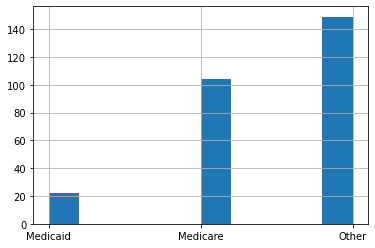

In [5]:
admissions['insurance'].hist()

In [6]:
admissions['admission_location'].drop_duplicates()

0                      TRANSFER FROM HOSPITAL
12     TRANSFER FROM SKILLED NURSING FACILITY
32         INTERNAL TRANSFER TO OR FROM PSYCH
38                         PHYSICIAN REFERRAL
51                             EMERGENCY ROOM
64                                       PACU
72                             PROCEDURE SITE
94                      WALK-IN/SELF REFERRAL
144                 INFORMATION NOT AVAILABLE
158                           CLINIC REFERRAL
Name: admission_location, dtype: object

<AxesSubplot:>

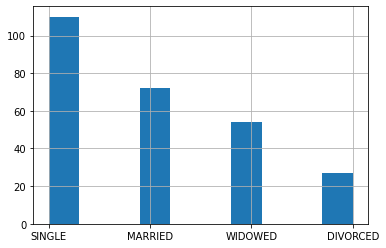

In [7]:
admissions['marital_status'].hist()

# <a class="anchor" id="Data-Preparation">Section III : Data Preparation</a>

Data is collected and stored by PhysioNet which is already clean and ready for analysis. we'll do some simple changes like dropping unnecessary columns and then merging all data together.

In [8]:
# Dropping unnecessary columns
admissions.drop(['admittime', 'dischtime','deathtime', 'language', 'edregtime', 'edouttime', 'discharge_location'], axis=1, inplace=True)
admissions.head()

,subject_id,hadm_id,admission_type,admission_location,insurance,marital_status,ethnicity,hospital_expire_flag
0,10004235,24181354,URGENT,TRANSFER FROM HOSPITAL,Medicaid,SINGLE,BLACK/AFRICAN AMERICAN,0
1,10009628,25926192,URGENT,TRANSFER FROM HOSPITAL,Medicaid,MARRIED,HISPANIC/LATINO,0
2,10018081,23983182,URGENT,TRANSFER FROM HOSPITAL,Medicare,MARRIED,WHITE,0
3,10006053,22942076,URGENT,TRANSFER FROM HOSPITAL,Medicaid,NaN,UNKNOWN,1
4,10031404,21606243,URGENT,TRANSFER FROM HOSPITAL,Other,WIDOWED,WHITE,0


In [9]:
patients.drop(['anchor_year_group', 'dod', 'anchor_year'], axis=1, inplace=True)
patients.head()

,subject_id,gender,anchor_age
0,10014729,F,21
1,10008454,F,26
2,10010867,F,28
3,10023239,F,29
4,10032725,F,38


In [10]:
icustays.drop(['first_careunit', 'last_careunit', 'intime', 'outtime'], axis=1, inplace=True)
icustays.head()

,subject_id,hadm_id,stay_id,los
0,10018328,23786647,31269608,7.702512
1,10020187,26842957,32554129,0.872685
2,10010867,22429197,39880770,9.362049
3,10018501,28479513,35446858,1.941215
4,10019568,28710730,30876334,0.815417


In [11]:
patients.shape[0] # Total number of patient records available

100

In [12]:
admissions.shape[0] # 275 times patients had been admitted

275

In [13]:
icustays.shape[0] # 140 admissions in ICU

140

Some patients have been transfered to ICU, some even more than once.
all patients that died have been transferred to ICU

In [14]:
# Checking multiple transfers to ICU

icu = icustays.loc[icustays['hadm_id'].isin(admissions['hadm_id'].values)]
duplicated = icu[icu['subject_id'].duplicated() == True].sort_values('subject_id').head()
icu_patients = icu.loc[icu['subject_id'].isin(duplicated['subject_id'])].sort_values(by='subject_id')
icu_patients

,subject_id,hadm_id,stay_id,los
62,10001217,24597018,37067082,1.118032
85,10001217,27703517,34592300,0.948113
36,10002428,20321825,34807493,2.023843
39,10002428,28662225,33987268,4.981134
42,10002428,28662225,38875437,7.032894
61,10002428,23473524,35479615,10.977222
49,10002930,25696644,37049133,1.135231
130,10002930,25922998,35629889,0.678970


In [15]:
icu_patients['subject_id'].drop_duplicates()

62    10001217
36    10002428
49    10002930
Name: subject_id, dtype: int64

only 3 patients have been trasnferred to ICU more than once, and only 1 patient (Subject_id: 10002428) had been transferred to ICU twice in the same admission.

In [16]:
icu_admission = icustays['hadm_id'].drop_duplicates()
admissions.loc[admissions['hadm_id'].isin(icu_admission.values.tolist())].shape[0]

128

out of 275 admissions, 128 were transfered to ICU at some point during their admission and have a Length of Stay (los) in the ICU ward which we'll add to our data.

Next we merge all data together in a single dataframe.

In [17]:
combined = admissions.merge(patients, on='subject_id')
combined = combined.merge(icustays, on='hadm_id', how='left')

In [18]:
combined.loc[combined[combined['los'].isna()].index, 'los'] = 0
combined.head()

,subject_id_x,hadm_id,admission_type,admission_location,insurance,marital_status,ethnicity,hospital_expire_flag,gender,anchor_age,subject_id_y,stay_id,los
0,10004235,24181354,URGENT,TRANSFER FROM HOSPITAL,Medicaid,SINGLE,BLACK/AFRICAN AMERICAN,0,M,47,10004235.0,34100191.0,4.952106
1,10004235,22187210,DIRECT EMER.,PHYSICIAN REFERRAL,Medicaid,SINGLE,BLACK/AFRICAN AMERICAN,0,M,47,NaN,NaN,0.000000
2,10004235,25970245,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicaid,SINGLE,BLACK/AFRICAN AMERICAN,0,M,47,NaN,NaN,0.000000
3,10009628,25926192,URGENT,TRANSFER FROM HOSPITAL,Medicaid,MARRIED,HISPANIC/LATINO,0,M,58,10009628.0,35258379.0,2.280752
4,10018081,23983182,URGENT,TRANSFER FROM HOSPITAL,Medicare,MARRIED,WHITE,0,M,79,NaN,NaN,0.000000


In [19]:
combined.shape[0] # Number of different admission available

287

In [20]:
combined.columns

Index(['subject_id_x', 'hadm_id', 'admission_type', 'admission_location',
       'insurance', 'marital_status', 'ethnicity', 'hospital_expire_flag',
       'gender', 'anchor_age', 'subject_id_y', 'stay_id', 'los'],
      dtype='object')

### Analyzing Deaths

In [21]:
combined[combined['hospital_expire_flag'] == 1]['hadm_id'].count() # Total number of patient deaths

20

Number of patients that have been to ICU during their admission and died.

In [22]:
# Total number of patients that have been in ICU and died

icu_patients = combined[combined['los'] > 0] # patients that have been in ICU
icu_patients[icu_patients['hospital_expire_flag'] == 1]['hadm_id'].count()

20

All patients that died have been admitted to ICU at some point during their admission at least once.

In [23]:
dead = combined[combined['hospital_expire_flag'] == 1]

In this part We'll take a glance at some of features available about the dead patients.

In [24]:
dead['gender'].describe()

count     20
unique     2
top        M
freq      16
Name: gender, dtype: object

 out of 20 deaths, 16 were Male, and 4 Females

In [25]:
dead['marital_status'].describe()

count          18
unique          3
top       MARRIED
freq           11
Name: marital_status, dtype: object

out of 20 deaths, 11 were married

In [26]:
dead['insurance'].describe()

count           20
unique           3
top       Medicare
freq            10
Name: insurance, dtype: object

out of 20 deaths, half of them had Medicare insurace.

In [27]:
dead['ethnicity'].describe()

count        20
unique        4
top       WHITE
freq         10
Name: ethnicity, dtype: object

out of 20 deaths, half of them were White

In [28]:
dead['admission_location'].describe()

count                 20
unique                 4
top       EMERGENCY ROOM
freq                  10
Name: admission_location, dtype: object

out of 20 deaths, half of them were admitted to the Emergency Room

In [29]:
dead['los'].describe()

count    20.000000
mean      5.927487
std       6.285489
min       0.023727
25%       0.826224
50%       4.271302
75%      10.436152
max      20.528681
Name: los, dtype: float64

out of 20 deaths, on average patients spend 6 Days in ICU

In [30]:
def dummy_creator(df=combined):
    '''
    Creates and returns a dataframe with dummy variables
    
    INPUT:
    df - (pandas dataframe) merged combined dataframe as defined at above
    
    OUTPUT:
    df_X - (pandas dataframe) processed dataframe with dummy variables
    
    '''
    # Selected Features
    columns = ['admission_type', 'admission_location', 'insurance', 'marital_status', 'ethnicity', 'gender']
    
    df = df[columns]
    df_X = pd.DataFrame()
    
    for col in columns:
        df_temp = pd.DataFrame()
        df_temp = pd.get_dummies(df[col], prefix=col[:3])
        df_X = pd.concat([df_X, df_temp], axis=1)
    return df_X

In [31]:
def column_appender():
    '''
    Appends remaining features to the dataframe with dummy variables and returns dataframe with all features
    
    INPUT:
    df - (pandas dataframe) merged combined dataframe as defined at above
    
    OUTPUT:
    df_final - (pandas dataframe) appended dataframe with dummy variables
    
    '''
    
    cols = ['anchor_age', 'los']
    df_final = pd.DataFrame()
    for col in cols:
        df_final = pd.concat([df_final, combined[col]], axis=1)
    df_final = pd.concat([dummy_creator(), df_final] , axis=1)
    
    return df_final

In [32]:
# Initializing the the explanatory matrix
X = column_appender()
X.head()

,adm_AMBULATORY OBSERVATION,adm_DIRECT EMER.,adm_DIRECT OBSERVATION,adm_ELECTIVE,adm_EU OBSERVATION,adm_EW EMER.,adm_OBSERVATION ADMIT,adm_SURGICAL SAME DAY ADMISSION,adm_URGENT,adm_CLINIC REFERRAL,...,eth_BLACK/AFRICAN AMERICAN,eth_HISPANIC/LATINO,eth_OTHER,eth_UNABLE TO OBTAIN,eth_UNKNOWN,eth_WHITE,gen_F,gen_M,anchor_age,los
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,47,4.952106
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,47,0.000000
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,47,0.000000
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,58,2.280752
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,79,0.000000


In [33]:
# Initializing the response vector

y = combined['hospital_expire_flag']
y.describe()

count    287.000000
mean       0.069686
std        0.255063
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: hospital_expire_flag, dtype: float64

Based on 287 admission records of 100 patients with 20 deaths, we'll start building our model

# <a class="anchor" id="Data-Modeling">Section IV : Data Modeling</a>

In this section we train a logistic regression using standard ML techniques like splitting data into train and test datasets.

In [43]:
# Splitting data into train and test dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

In [44]:
model = LogisticRegression(C=0.001, solver='newton-cg')
model.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='newton-cg')

In [45]:
# Checking which solver works best

solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver=solver_list)
clf = GridSearchCV(model, params, n_jobs=2) 
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']

for score, solver in zip(scores, solver_list):
    print(f"  {solver} {score:.3f}" )

  liblinear 0.925
  newton-cg 0.935
  lbfgs 0.935
  sag 0.930
  saga 0.930


> In the above cell, GridSearchCV returns a warning "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge", which is cleared by setting the n_jobs more than 1

Above Cell shows that with this dataset, top 3 solver algorithms are:

1. lbfgs (default)
2. netwon-cg
3. liblinear

** sag and saga are more suitable for larger datasets.

Lastly we use Grid Search Cross Validation to optimize our Logistic Regression Hyperparamters.

In [46]:
# Checking the parameters in the classifier

model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [47]:
# Defining list of possible values for hyperparameters

c_list = [.001, .01, .1, 1, 10, 100, 1000]
boolean = [True, False]
params = {"C": c_list,
          "fit_intercept": boolean}

clf = GridSearchCV(model, params)  # Cross-Validating
clf.fit(X_train, y_train)

print('Best Score: %s' % clf.best_score_)
print('Best Hyperparameters: %s' % clf.best_params_)

Best Score: 0.9349999999999999
Best Hyperparameters: {'C': 0.001, 'fit_intercept': True}


# <a class="anchor" id="Results-Evaluation">Section V : Results Evaluation</a>

### Question 1: Can patient healthcare records predict the likelihood of mortality in an emergency room visit?

In this section we'll go through our results, and in the next section we'll answer this question

We will be interested in computing the Area under the ROC curve (AUC), so we need to compute the predicted probability and compare to the true label. Also, before getting to the AUC, we'll be checking our results with a confusion matrix and classification report.

In [48]:
ypred = model.predict(X_test)
confusion = confusion_matrix(y_test, ypred)
confusion

array([[79,  1],
       [ 4,  3]], dtype=int64)

Our confusion matrix indicates that our trained model predicted:

* 82 Correct
* 5 Incorrect

In [49]:
print(classification_report(y_test, ypred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        80
           1       0.75      0.43      0.55         7

    accuracy                           0.94        87
   macro avg       0.85      0.71      0.76        87
weighted avg       0.94      0.94      0.94        87



* Out of all the patients that the model predicted that would die, 75% actually did.
* Out of all the patients that actually died, the model only predicted this outcome correctly for 43% of those patients.

In [50]:
y_train[y_train == 1].count() # Number of deaths in train data

13

In [51]:
y_test[y_test == 1].count() # Number of deaths in test data

7

We would want to build a model with a higher AUC, as more are under the curve our model is covering, the better our model can predict.

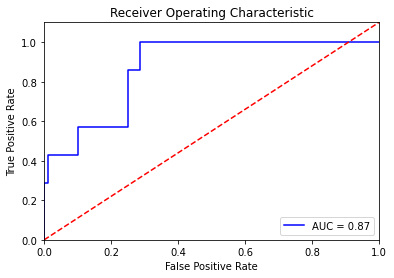

In [52]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1.1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Our trained model have 87% AUC, which shows it's working fairly okay, or is it?

In [57]:
dic = dict()
for i,j in zip(X.columns, model.coef_[0]):
    if not (j == 0):
        dic[i] = j
        
        
df = pd.DataFrame(dic, index=[0])
df = df.T.sort_values(by=0)

len(df.index.tolist())

35

We used a total 35 features to predict patients mortality likelihood based upon.

In the last step we'll examine how does each feature is contributing to a person's likelihood of dying? We can examine the LR coefficients for that.

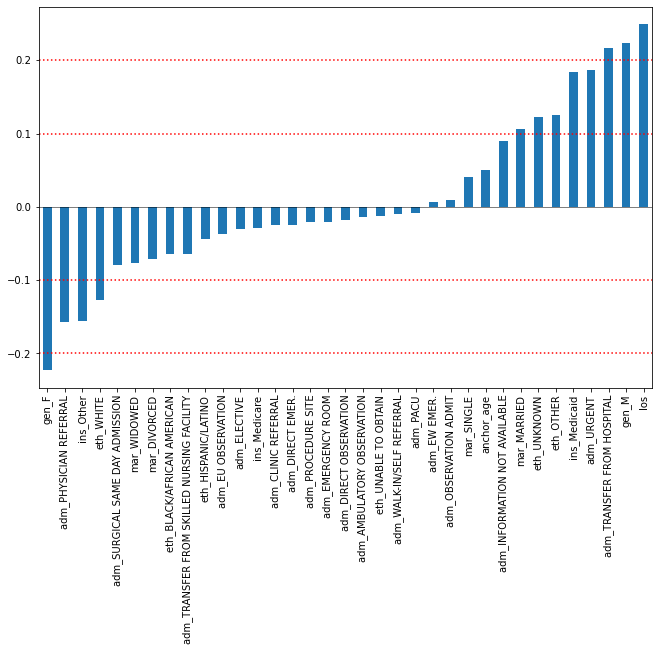

In [58]:
fig, ax = plt.subplots(figsize=(11,7))
df.plot.bar(ax=ax)
ax.legend().remove()
ax.axhline(y = 0, c='k', lw=0.5)
ax.axhline(y = 0.1, c='r', ls=':', lw=1.5)
ax.axhline(y = 0.2, c='r', ls=':', lw=1.5)
ax.axhline(y = -0.1, c='r', ls=':', lw=1.5)
ax.axhline(y = -0.2, c='r', ls=':', lw=1.5)
plt.show()

The chart above shows the most to least contributed features we selected in the mortality prediction.

Most contributed features in death according to the above chart in our model is:

1. LOS (Length Of Stay) in ICU
2. Gender: Male
3. Admission Type: Transfer From Hospital
4. Admission Type: Urgent
5. Insurance: Medicaid
6. Ethnicity: Other
7. Ethnicity: Unkown
8. Marital Status: Married

# <a class="anchor" id="Conclusion-Discussion">Section VI: Conclusion and Discussion</a>

Now to answer our aforementioned question, Yes using MIMIC database we can predict mortality likelihood in hospital or different wards of hospital individually. However, data used in this notebook was a demo version of MIMIC due to unavailablity and application approval process time. The sample space was consisted of only 100 patients with 20 deaths. Because of the small sample space we couldn't limit the data to only Emergency Room visits, but with a larger dataset we can analyze different sections of a hospital.

According to our results, due to the small number of patient records and number of deaths, it shows that our model is working poorly because of this issue. Additionaly, as mentioned above, In our dead patients only 4 of them were Females. Hence, Male gender was a high contributer to the patient's death in our limited dataset, not to the general public. Moreover, with a train size of 70%, In the last run, we have 13 deaths in our train dataset, and only 7 deaths in our test dataset. If the train size is set to higher values like .75 or .8, less than 5 deaths will be available in the test dataset and our model usually performs poorly and predicts deaths with 0 percision.

Lastly, we can select better features like Patients Vital Signs which are available in the original dataset and are better features to predict a patients mortality rate based upon rather than ethnicity, insurance, and etc. Additionally, there are other data available as well to use but need a preprocessing first. For instance, procedures and diagnosis of a patient. However, in each table there are multiple procedures and diagnosis a patient has which is labeled with a seq_num and a seq_num = 1 indicates a higher priority in the patients diagnosis or procedure. We can first label each procedure and diagnosis with a shorter title, then we can use the diagnosis or procedure with the highest priority in our model. However, a domain expert would be needed to conduct the preprocessing without eliminating important data. Next the model needs to be trained with these new features then be evaluated to see how each feature does actually contribute to the outcome.

* it's worth mentioning that in some conducted researches on MIMIC demo database, because the anchor_age is de-identified, any patients that are older than 89 their anchor_age is set to 91, regardless of how old they actually were. Consequently, this age range is removed from the data completely, but in this case due to the few number of records available no elimination has been done.